In [1]:
!pip install -U tensorflow


  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cach

In [2]:
import intake
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-08 16:33:01.411424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 16:33:01.587269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 16:33:01.587312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-08 16:33:01.624589: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 16:33:02.434745: W tensorflow/stream_executor/platform/de

In [3]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

In [4]:
ds_forcing = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)

In [5]:
cat = intake.open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml')


In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33601")
client

<Client: 'tcp://127.0.0.1:33601' processes=4 threads=16, memory=58.88 GiB>

In [7]:
snapshots = cat["snapshots1ka"].to_dask()

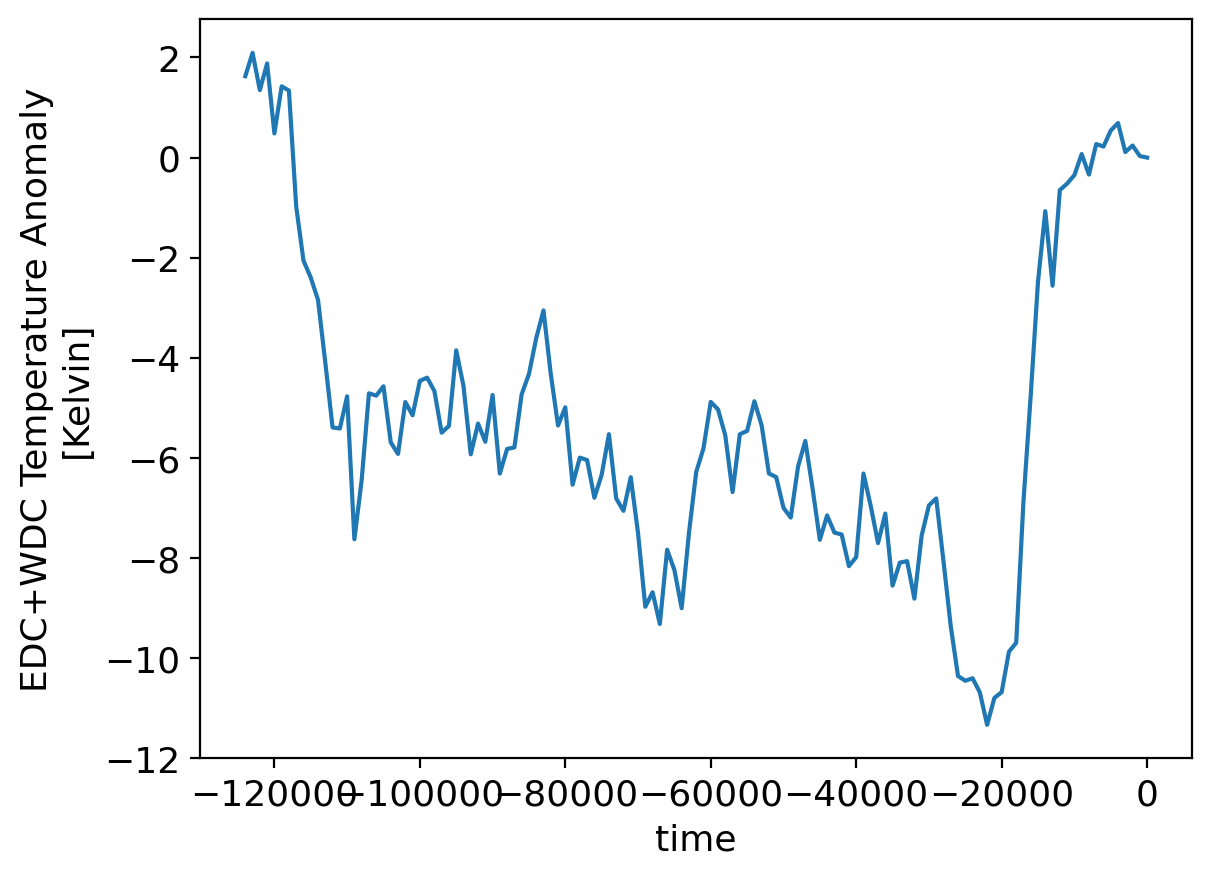

In [8]:
ds_forcing_interp = ds_forcing.interp(time=snapshots.time)
ds_forcing_interp.delta_T.plot()

In [9]:
ds_forcing_interp.delta_T.coords['time'].data

array([-124000., -123000., -122000., -121000., -120000., -119000.,
       -118000., -117000., -116000., -115000., -114000., -113000.,
       -112000., -111000., -110000., -109000., -108000., -107000.,
       -106000., -105000., -104000., -103000., -102000., -101000.,
       -100000.,  -99000.,  -98000.,  -97000.,  -96000.,  -95000.,
        -94000.,  -93000.,  -92000.,  -91000.,  -90000.,  -89000.,
        -88000.,  -87000.,  -86000.,  -85000.,  -84000.,  -83000.,
        -82000.,  -81000.,  -80000.,  -79000.,  -78000.,  -77000.,
        -76000.,  -75000.,  -74000.,  -73000.,  -72000.,  -71000.,
        -70000.,  -69000.,  -68000.,  -67000.,  -66000.,  -65000.,
        -64000.,  -63000.,  -62000.,  -61000.,  -60000.,  -59000.,
        -58000.,  -57000.,  -56000.,  -55000.,  -54000.,  -53000.,
        -52000.,  -51000.,  -50000.,  -49000.,  -48000.,  -47000.,
        -46000.,  -45000.,  -44000.,  -43000.,  -42000.,  -41000.,
        -40000.,  -39000.,  -38000.,  -37000.,  -36000.,  -350

In [10]:
X_df = pd.DataFrame({"delta_T": ds_forcing_interp.delta_T.data},index=ds_forcing_interp.delta_T.coords['time'].data)

First let's test by training on one ensemble member (will be overfit)

In [11]:
y_array = snapshots.velbar_mag.isel(par_esia=0,par_ppq=0,par_prec=0,par_visc=0).load()

In [12]:
y_array

<xarray.DataArray 'velbar_mag' (time: 125, y: 381, x: 381)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    par_esia  float64 1.0
    par_ppq   float64 0.25
    par_prec  float64 0.02
    par_visc  float64 1e+20
  * time      (time) float64 -1.24e+05 -1.23e+05 -1.22e+05 ... -2e+03 -1e+03 0.0
  * x         (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y         (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
Attributes:
    coordinates:  lat lon
    long_name:    magnitude of vertically-integrated horizontal velocity of ice
    pism_intent:  diagnostic
    units:        m year-1
    valid_min:    0.0

In [13]:
y_df_stack = y_array.stack(dim=["y", "x"])


In [14]:
y_df_stack

<xarray.DataArray 'velbar_mag' (time: 125, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    par_esia  float64 1.0
    par_ppq   float64 0.25
    par_prec  float64 0.02
    par_visc  float64 1e+20
  * time      (time) float64 -1.24e+05 -1.23e+05 -1.22e+05 ... -2e+03 -1e+03 0.0
  * dim       (dim) object MultiIndex
  * y         (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x         (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    coordinates:  lat lon
    long_name:    magnitude of vertically-integrated horizontal velocity of ice
    pism_intent:  diagnostic
    units:        m year-1
    valid_min:    0.0

In [15]:
y_df = pd.DataFrame(y_df_stack.to_pandas())

In [16]:
y_df = y_df.fillna(0)

Note! Drop NAs - Ask prof.

In [17]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2)

Split without random times. 

In [18]:
y_train_df.isnull().values.any()

False

In [19]:
print(X_train_df.shape,y_train_df.shape)

(100, 1) (100, 145161)


In [20]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(100, 1) (100, 145161)


In [26]:
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.01
minibatch_size = 4
model_num      = 1

In [27]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                128       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 145161)            9435465   
                                                                 
Total params: 9,443,913
Trainable params: 9,443,913
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
20/20 [==============================] - 1s 35ms/step - loss: 26096.8750 - val_loss: 25212.8750
Epoch 2/50
20/20 [==============================] - 1s 31ms/step - loss: 18230.8125 - val_loss: 18601.4375
Epoch 3/50
20/20 [==============================] - 1s 30ms/step - loss: 15031.9971 - val_loss: 17587.3652
Epoch 4/50
20/20 [==============================] - 1s 30ms/step - loss: 14503.7832 - val_loss: 17636.5488
Epoch 5/50
20/20 [==============================] - 1s 30ms/step - loss: 14504.5205 - val_loss: 17600.7617
Epoch 6/50
20/20 [==============================] - 1s 31ms/step - loss: 14390.9316 - val_loss: 17604.4805
Epoch 7/50
20/20 [==============================] - 1s 30ms/step - loss: 14422.7266 - val_loss: 17671.6895
Epoch 8/50
20/20 [==============================] - 1s 31ms/step - loss: 14367.7393 - val_loss: 17593.0977
Epoch 9/50
20/20 [==============================] - 1s 30ms/step - loss: 14387.3936 - val_loss: 17651.3906
Epoch 10/50
20/20 [==================

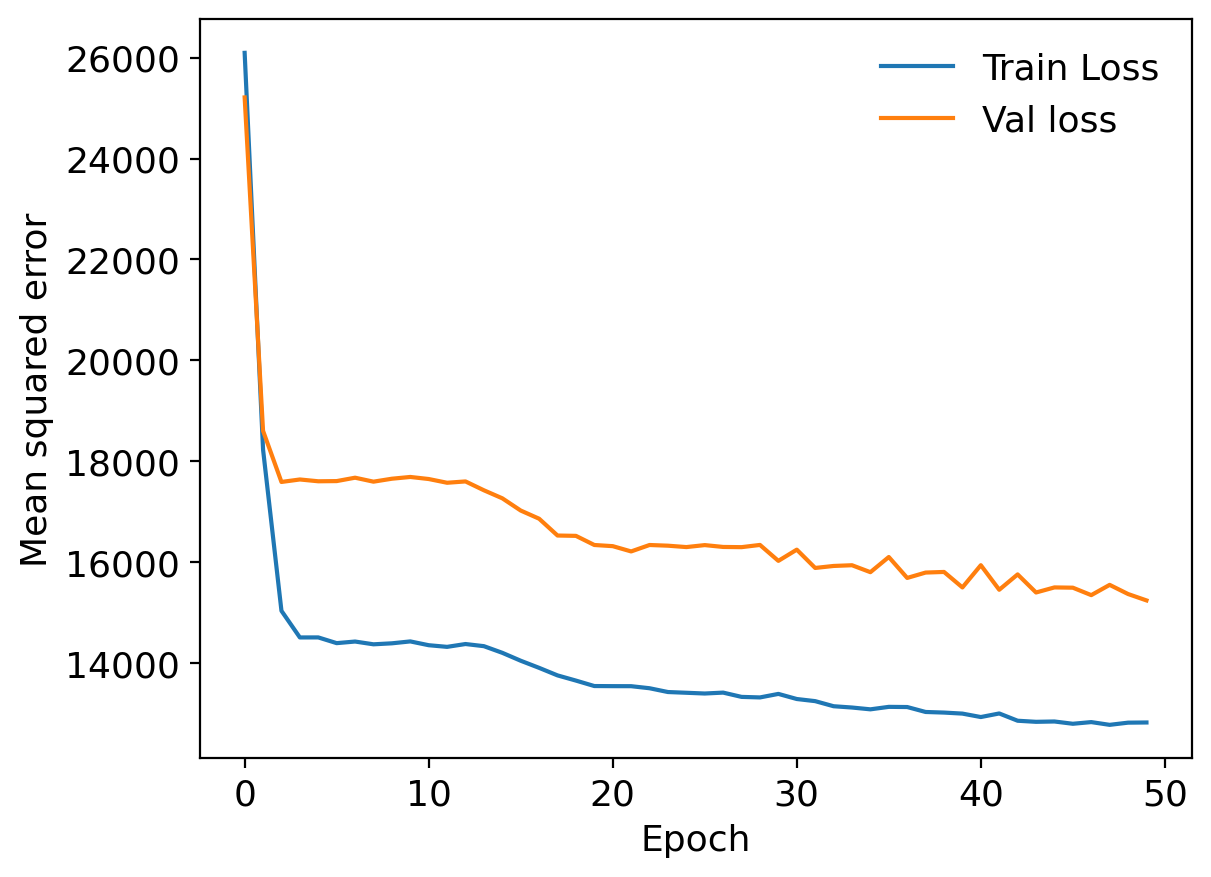

In [30]:
plot_history(history)

In [31]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [32]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model_1_member.h5'))

In [33]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model_1_member.h5'))

In [34]:
y_test_pre = model.predict(X_test)


1/1 [==============================] - 0s 88ms/step


In [35]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.index.values.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': y_test_df.index.values, 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velbar_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [36]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:     (time: 25, y: 381, x: 381)
Coordinates:
  * time        (time) float64 -1.2e+04 -3.2e+04 -5.9e+04 ... -1e+04 -1.8e+04
  * x           (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y           (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velbar_mag  (time, y, x) float32 0.03442 -1.379 0.4465 ... 0.1548 0.2723

In [37]:
y_true = y_test_df.unstack().to_xarray()

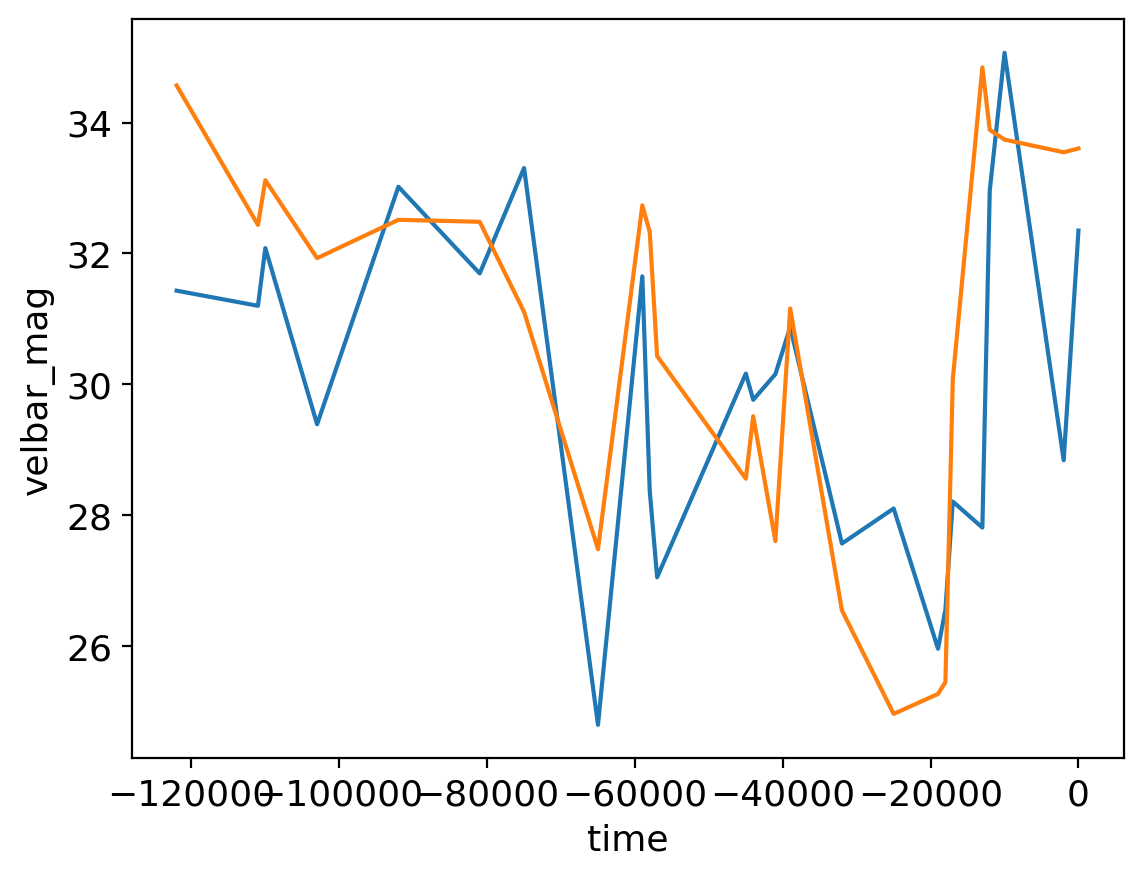

In [38]:
y_true.sortby(y_true.time).mean(dim=['x','y']).plot()
y_test_pre_xr.velbar_mag.sortby(y_test_pre_xr.time).mean(dim=['x','y']).plot()

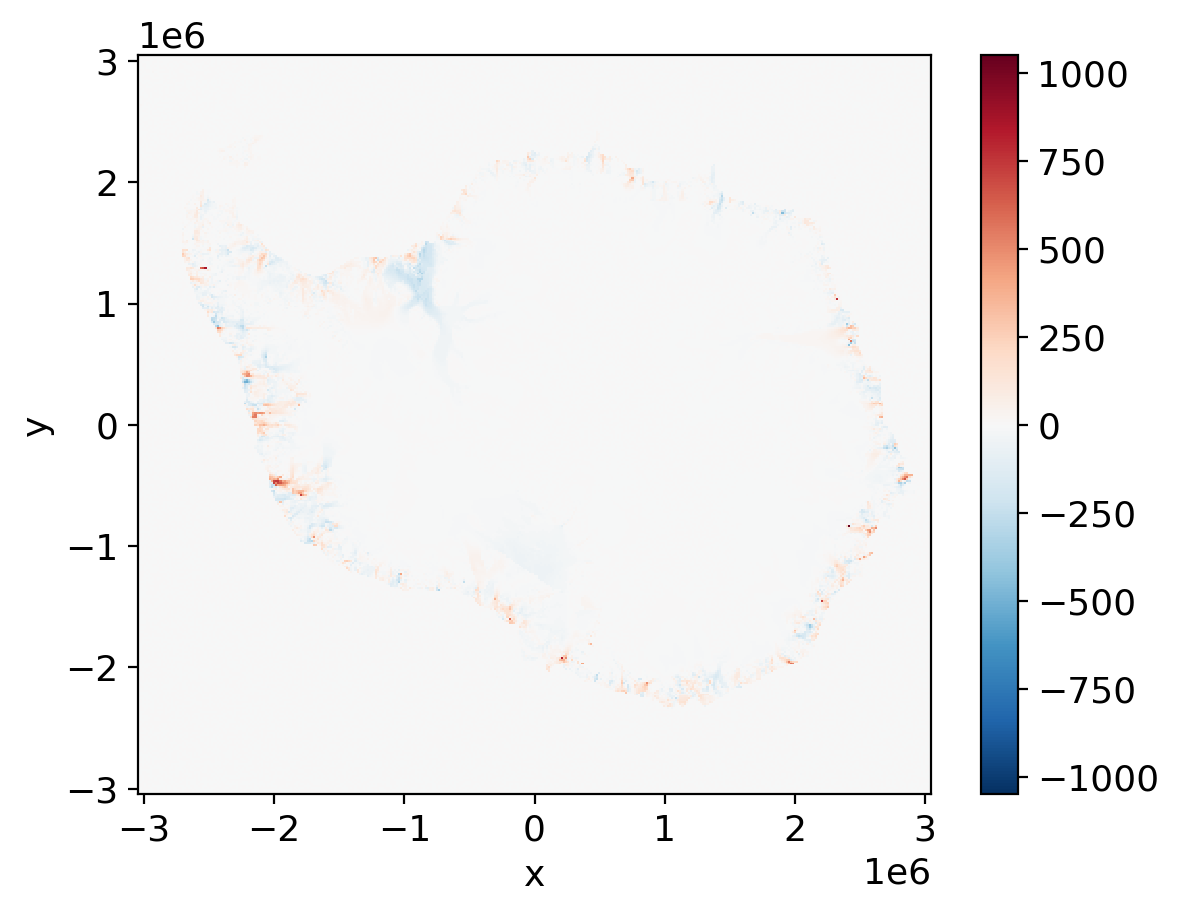

In [39]:
(y_true-y_test_pre_xr.velbar_mag).mean(dim='time').plot()

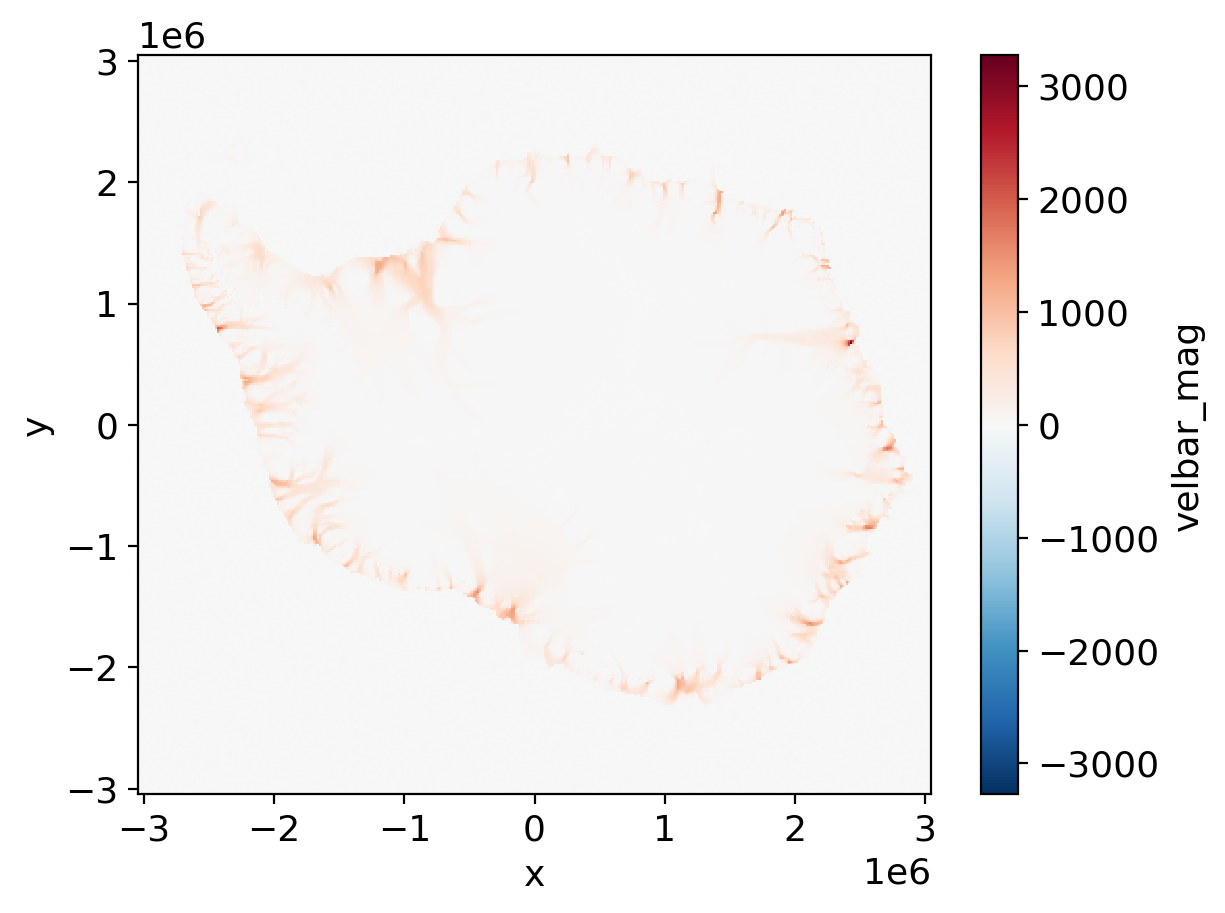

In [40]:
y_test_pre_xr.velbar_mag.mean(dim='time').plot()

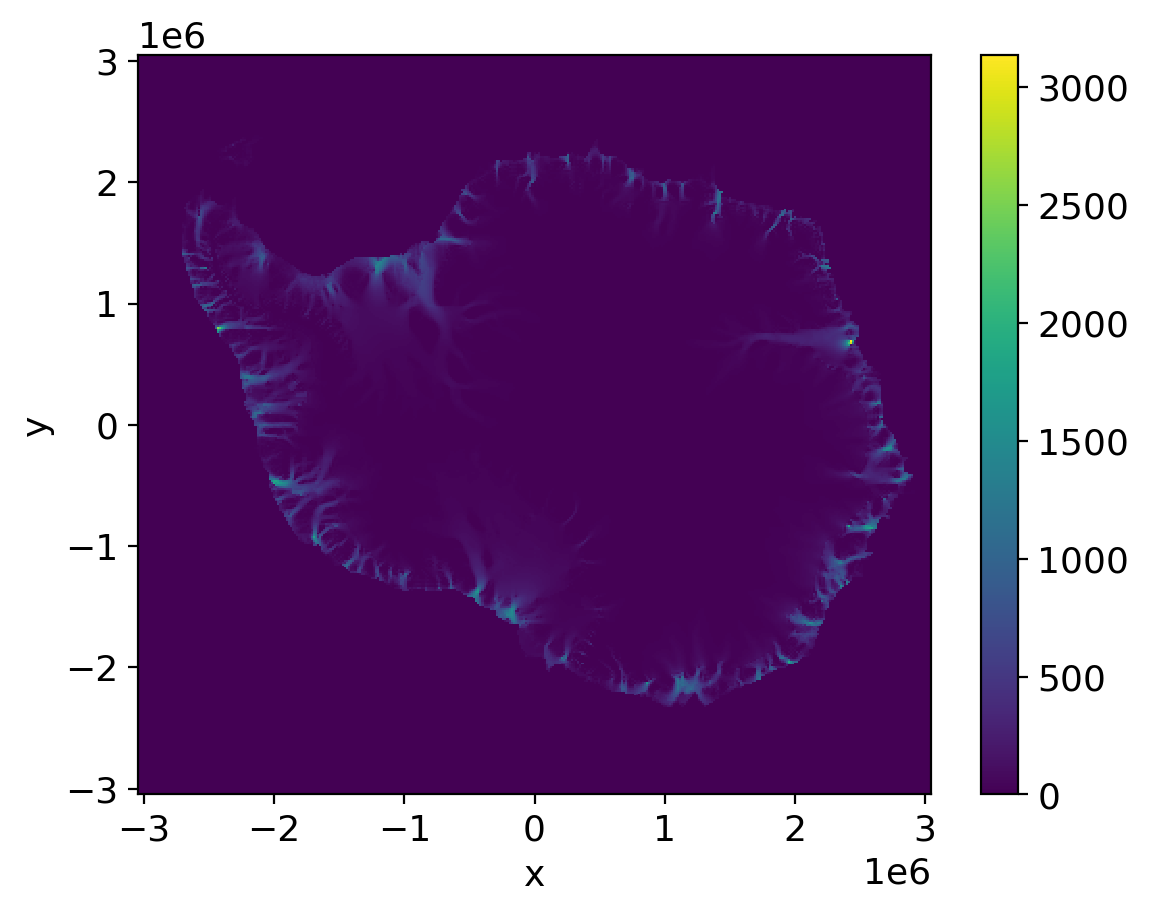

In [41]:
y_true.mean(dim='time').plot()

Make a scatter plot to see fit. Manually calculate RMSE or r squared